In [3]:
import pandas as pd
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import yfinance as yf
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping

In [5]:
stock_data = pd.read_csv('../data/stock_data.csv')
# stock_data_test = pd.read_csv('./data/stock_data_test.csv')
stock_data.tail()

,Date,Open,Adj Close,Volume,SMA_50,SMA_200,MACD_12_26_9,MACDh_12_26_9,MACDs_12_26_9,RSI_14,Volatility,Daily_Return,interest_rate,vix,msft,fast,low,nsdq,spy
1441,2023-09-25,174.199997,175.624237,46172700,182.527935,164.880386,-2.000791,-0.232289,-1.768502,44.397096,0.015542,0.007380,4.542,16.900000,316.311890,53.812160,210.202179,13271.320312,4337.439941
1442,2023-09-26,174.820007,171.514893,64588900,182.093694,165.038071,-2.247586,-0.383267,-1.864319,38.386669,0.016171,-0.023399,4.558,18.940001,310.932770,53.488049,206.284988,13063.610352,4273.529785
1443,2023-09-27,172.619995,169.988846,66921800,181.634111,165.179634,-2.537382,-0.538451,-1.998931,36.415084,0.015199,-0.008897,4.626,18.219999,311.580231,54.077339,204.722092,13092.849609,4274.509766
1444,2023-09-28,169.339996,170.248184,56294400,181.152424,165.324926,-2.714773,-0.572673,-2.142100,37.007197,0.014283,0.001526,4.597,17.340000,312.426971,54.656811,205.533218,13201.280273,4299.700195
1445,2023-09-29,172.020004,170.766846,51814200,180.720354,165.461242,-2.781335,-0.511388,-2.269947,38.245764,0.014329,0.003047,4.573,17.520000,314.528778,53.664833,205.592560,13219.320312,4288.049805


### Preprocessing

In [6]:
stock_data = stock_data.drop(columns=['Date'])
stock_data = stock_data.fillna(stock_data.mean())
# Normalize Dataset
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(stock_data)

# stock_data_test = stock_data_test.drop(columns=['Date'])
# stock_data_test = stock_data_test.fillna(stock_data.mean())
# scaled_data_test = scaler.transform(stock_data_test)  # Use the same scaler

def create_dataset(dataset, time_step=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-time_step):
        a = dataset[i:(i+time_step), :]
        dataX.append(a)
        dataY.append(dataset[i + time_step, 1])  # Predicting the next closing price
    return np.array(dataX), np.array(dataY)

time_step = 500  # number of previous time steps to consider
X, y = create_dataset(scaled_data, time_step)
# X_test, y_test = create_dataset(scaled_data_test, time_step)

X = np.reshape(X, (X.shape[0], X.shape[1], scaled_data.shape[1]))
# X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], scaled_data_test.shape[1]))

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.1, random_state=42)

### Build Model

In [9]:
model = Sequential()
model.add(LSTM(units=50, return_sequences=True, input_shape=(500, 18)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))  # Predicting the next closing price

model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_3 (LSTM)               (None, 500, 50)           13800     
                                                                 
 dropout_3 (Dropout)         (None, 500, 50)           0         
                                                                 
 lstm_4 (LSTM)               (None, 500, 50)           20200     
                                                                 
 dropout_4 (Dropout)         (None, 500, 50)           0         
                                                                 
 lstm_5 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_5 (Dropout)         (None, 50)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                

In [10]:
#model.fit(X, y, epochs=10, batch_size=32, verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, verbose=1, mode='min', restore_best_weights=True)
model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=32, verbose=1, callbacks=[early_stopping])

Epoch 1/30
27/27 [==============================] - 12s 313ms/step - loss: 0.0531 - val_loss: 0.0098
Epoch 2/30
27/27 [==============================] - 7s 277ms/step - loss: 0.0108 - val_loss: 0.0037
Epoch 3/30
27/27 [==============================] - 8s 282ms/step - loss: 0.0083 - val_loss: 0.0031
Epoch 4/30
27/27 [==============================] - 8s 284ms/step - loss: 0.0075 - val_loss: 0.0024
Epoch 5/30
27/27 [==============================] - 8s 288ms/step - loss: 0.0065 - val_loss: 0.0027
Epoch 6/30
27/27 [==============================] - 8s 292ms/step - loss: 0.0070 - val_loss: 0.0020
Epoch 7/30
27/27 [==============================] - 8s 298ms/step - loss: 0.0058 - val_loss: 0.0030
Epoch 8/30
27/27 [==============================] - 13s 486ms/step - loss: 0.0056 - val_loss: 0.0015
Epoch 9/30
27/27 [==============================] - 18s 683ms/step - loss: 0.0056 - val_loss: 0.0018
Epoch 10/30
27/27 [==============================] - 20s 733ms/step - loss: 0.0052 - val_loss: 0.

### Make Predictions

In [15]:
last_100_days = scaled_data[-500:]
predicted_prices = []

# Predict the next 30 days
for i in range(22):
    # Reshape the input for the model
    X_test = last_100_days.reshape((1, last_100_days.shape[0], last_100_days.shape[1]))
    
    # Predict the next price
    predicted_price = model.predict(X_test)
    
    # Update the last 100 days to include the new prediction
    last_100_days = np.append(last_100_days, [scaled_data[-1]], axis=0)
    last_100_days = last_100_days[1:]
    
    # Store the predicted price
    predicted_prices.append(predicted_price[0][0])

# Inverse transform the predicted prices to get actual values
predicted_prices = np.array(predicted_prices).reshape(-1, 1)

dummy_array = np.zeros((len(predicted_prices), scaled_data.shape[1]))
dummy_array[:, 1] = np.squeeze(predicted_prices)

# Inverse transform the dummy array
transformed_data = scaler.inverse_transform(dummy_array)

# Extract the stock prices
actual_predicted_prices = transformed_data[:, 1]
actual_predicted_prices

1/1 [==============================] - 0s 50ms/step


array([171.72356349, 171.26611965, 170.83903657, 170.44923982,
       170.10066898, 169.7946244 , 169.5303933 , 169.3056832 ,
       169.117354  , 168.9616684 , 168.83463866, 168.73243116,
       168.65122189, 168.5876107 , 168.5385249 , 168.50125783,
       168.47348814, 168.45325084, 168.43885067, 168.42897764,
       168.42256258, 168.41862301])

### Compare with actual prices

In [16]:
ticker = 'AAPL'
start_date = '2023-10-01'
end_date = '2023-11-01'

def get_stock_data(ticker, start_date, end_date):
    stock_data = yf.download(ticker, start = start_date, end = end_date)
    return stock_data

test_data = get_stock_data(ticker, start_date, end_date)
actual_close = test_data['Adj Close'].tolist()
actual_close

[*********************100%%**********************]  1 of 1 completed


[173.3002471923828,
 171.9537353515625,
 173.2104949951172,
 174.45726013183594,
 177.03057861328125,
 178.52670288085938,
 177.92825317382812,
 179.3345947265625,
 180.24224853515625,
 178.38706970214844,
 178.25738525390625,
 176.6914520263672,
 175.3848419189453,
 175.00584411621094,
 172.43251037597656,
 172.5522003173828,
 172.99105834960938,
 170.65711975097656,
 166.4580078125,
 167.78456115722656,
 169.8491973876953,
 170.32797241210938]

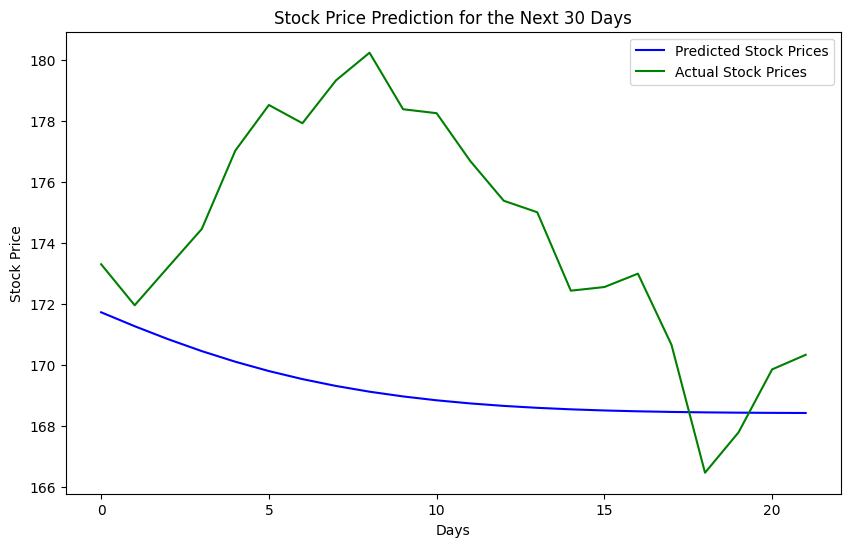

In [17]:
plt.figure(figsize=(10, 6))
plt.plot(actual_predicted_prices,  color='blue', label='Predicted Stock Prices')
plt.plot(actual_close,  color='green', label='Actual Stock Prices')
plt.title('Stock Price Prediction for the Next 30 Days')
plt.xlabel('Days')
plt.ylabel('Stock Price')
plt.legend()
plt.show()